# Ejemplo práctico 1: Cadenas Palíndromas
 
En esta sección aplicaremos las lecciones aprendidas sobre computación reversible por medio del paquete de programación *Qiskit* para Python, producido por IBM. Nos concentraremos en resolver un problema estándar de computación:

> ¿Cómo podemos determinar si una cadena binaria es palíndroma?

Invitamos al lector a intentar resolver este problema utilizando la librería estándar de Python. Aquí, utilizaremos el modelo de computación por medio de circuitos lógicos, realizando únicamente operaciones reversibles como las compuertas NOT, CNOT y Toffoli. Antes de realizar la programación de un circuito lógico con *Qiskit*, es prudente analizar el problema a resolver y proponer un algoritmo tentativo.

## Análisis del problema

Una **cadena binaria palíndroma** es aquella que se lee igual de izquierda a derecha, que de derecha a izquierda. Esto se ilustra mejor con un ejemplo sencillo.

> La cadena *101101* es palíndroma, mientras que la cadena *111000* no lo es

Queremos diseñar un algoritmo, programable en un circuito lógico, cuyo resultado nos permita decidir si una cadena arbitraria de *n* bits es palíndroma o no. Puesto que deseamos responder una pregunta sobre el valor de veracidad de una proposición, nuestro algoritmo debe corresponder al cómputo de una función del estilo

$$f(q_0q_1q_2 \cdots q_n) = \begin{cases}1 & q_0q_1q_2 \cdots q_n \text{ es palíndroma} \\ 0 & \text{ en otro caso}\end{cases}$$

Por tanto, el algoritmo que diseñemos debe tomar como entrada la cadena de bits $q_0q_1q_2 \cdots q_n$, y tener como salida un bit $p_0$, que nos indique la veracidad de la proposición *la cadena $q_0q_1q_2 \cdots q_n$ es palíndroma*. 

Consideremos un ejemplo práctico. Supongamos que deseamos determinar si la cadena *11011* es palíndroma. Inmediatamente aseveramos que la afirmación es cierta, puesto que el último bit y el primero de la cadena son iguales; así como el segundo y el cuarto. Un posible algoritmo consiste en comparar el $i$-esimo bit de la cadena con el $(n-i-1)$-ésimo bit, y determinar si **todos** los pares correspondientes que se pueden formar de la misma son iguales. Si esto sucede, entonces la cadena es palíndroma. En caso contrario, no lo es. Resumimos nuestro algoritmo de la siguiente forma:

>1. Compare los bits de la cadena $q_0q_1q_2 \cdots q_n$ a pares, $q_i$ con $q_{n-1-i}$, para $i=0,\ldots,n/2$. Guarde los resultados de la comparación en $q_i$ o $a_{n-1-i}$. Estos se denotan con $q'_i$ para $i=0,\ldots,n/2$.
>1. Puesto que $q'_i$ son los valores de verdad de las proposiciones *$q_i$ y $q_{n-1-i}$ son iguales*, la cadena es palíndroma si $q'_0 \land q'_1 \land \cdots \land q'_{n/2} = 1$. Así que **se debe computar esta proposición reversiblemente**. Guarde el resultado del cómputo en $p_0$.
>1. Es posible que se necesiten utilizar bits de ancila para hacer la computación reversible. Como se vio en secciones anteriores, todos los cómputos que han modificado la cadena de entrada y los bits de ancila deben ***des-computarse***
>1. Mida $p_0$ para leer el valor de verdad de la proposición *la cadena $q_0q_1q_2 \cdots q_n$ es palíndroma*.

Al seguir este algoritmo, podremos resolver el problema. La siguiente imagen resume el procedimiento que deseamos seguir.

![png](Lec_1_Palindromos_files/demoAlgorithm.png)

Los pasos del algoritmo anterios los implementaremos en *Qiskit* en la siguiente sección.

## Implementación de una posible solución en *Qiskit*

*Qiskit* es una herramienta para programación de circuitos cuánticos en Python. Por el momento, no nos preocuparemos de la naturalez cuántica de los bits que se utilizan. Para el problema que nos concierne, estos se pueden considerar como bits clásicos. La diferencia esencial en este punto es que *los bits cuánticos o qubits deben ser medidos para poder determinar el resultadod el cómputo*. En esta lección simularemos un circuito reversible capaz de resolver el problema propuesto. 

### Importación de Librerías

Para ello necesitaremos importar de *Qiskit*:

* ```QuantumCircuit```: Es la función que nos permite construir un circuito con compuertas lógicas.
* ```QuantumRegister```: Es la herramienta que nos permite inicializar un **registro de bits**. Por defecto, todos empiezan un cómputo en estado 0.
* ```ClassicalRegister```: Aunque no nos preocuparemos por la naturaleza cuántica de los bits, adelantamos que este es un registro de bits donde se almacenan los resultados de la medición de los bits en un ```QuantumRegister```.
* ```Aer```: Es la librería que nos permite simular el cómputo en un dispositivo clásico.
* ```execute```: Es la función que nos permite ejecutar un algoritmo representado como un circuito lógico.
* ```plot_histogram```: Es la función que nos permitirá leer la salida tras la ejecución del algoritmo.

**NOTA:** Estas importaciones ya han sido realizadas anteriormente para demostrar los ejemplos teóricos. Sin embargo, las incluimos en este punto para recordar su estructura.

In [4]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

### Implementación del algoritmo

Probaremos el algoritmo con un ejemplo particular. Definimos la cadena que queremos evaluar, con una longitud de 4 bits. Vale aclarar que hemos creado un entorno virtual en **MyBinder** donde esta lección puede seguirse interactivamente por medio de un notebook de Jupyter. Allí es posible modificar la cadena a evaluar. Para acceder a este, el lector puede hacer click en el botón.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/QC-FEM/QC-CrashCourse/HEAD)

In [2]:
cadena = '1001'

#### 0. Creación del espacio necesario

Definimos el registro cuántico donde se va a realizar el procesamiento de la cadena, así como el registro clásico donde se va a almacenar el resultado del cómputo. A partir de nuestro análisis, sabemos que necesitamos al menos 3 registros:

1. Un registro para la cadena a evaluar, que llamaremos ```cadena_procesada```
1. Un registro para la ancila, que llamaremos ```ancila```
1. Un registro para guardar el resultado del cómputo, que llamaremos ```es_palind```

Notemos lo siguiente:

* Es claro que el registro de la cadena debe tener el mismo número de bits que la cadena en sí. Denotaremos este número por ```nbits```.

* Sabemos que la ancila la necesitaremos para el paso 2, específicamente, para calcular los ANDs. Esto lo vimos en los ejemplos teóricos. Por cada AND que debamos computar, necesitaremos un bit de ancila. Si la cadena que queremos evaluar tiene ```nbits``` bits, debemos computar ```nbits//2``` ANDs, y necesitaremos ```nbits//2-1``` bits de ancila.

* Claramente, el registro para guardar el resultado solo necesita un bit, puesto que evaluaremos la veracidad de una proposición: *la cadena $q_0q_1q_2 \cdots q_n$ es palíndroma*

Estos registros serán declarados como ```QuantumRegister```, si bien en esta lección no explotaremos a fondo su naturaleza cuántica.

Finalmente, por cuestiones que veremos en siguientes lecciones, es necesario hacer explícito el proceso de medición del resultado. Esto puede parecer extraño para los científicos de la computación. Sin embargo, vale la pena recordar que incluso en su procesador clásico, los bits lógicos corresponden a señales de corriente y voltaje que **deben ser medidos** de alguna manera para reproducir los resultados de sus programas en la salida estándar de su procesador. 

>Un factor importante que un científico de la computación debe tener en cuenta al embarcarse en el mundo de la computación cuántica es que la información se procesa en sistemas físicos reales, cuya dinámica determina sus capacidades para realizar las tareas que un programador requiere.

Aquel espacio donde almacenaremos los resultados de la medición de los registros será un registro clásico, declarado como ```ClassicalRegister```. Se compondrá de dos registros:

1. Un registro para leer el resultado del cómputo, que llamaremos ```mido_palind```
1. Un registro para leer la cadena a evaluar, que llamaremos ```cadena_medida```

A continuación tenemos el código necesario para crear este espacio

In [16]:
## Guardamos la longitud de la cadena por facilidad
nbits = len(cadena)
## Registro para procesamiento
cadena_procesada = QuantumRegister(nbits,name='q')
## Registro de ancila
ancila = QuantumRegister(nbits//2-1,name='a')
## Registro de salida
es_palind = QuantumRegister(1,name= 'p')
## Registro para la medición
mido_palind = ClassicalRegister(1,name='p_m')
## Registro para procesamiento
cadena_medida = ClassicalRegister(nbits,name='q_m')

Finalmente, iniciamos el circuito por medio de la función ```QuantumCircuit```. Podemos probar que el circuito se ha creado correctamente por medio de la función miembro ```circuit.draw()```. Si el lector desea que el circuito sea dibujado por medio de matplotlib, debe utilizar la opción ```output='mpl'```.

In [17]:
qc_palindromo = QuantumCircuit(cadena_procesada,ancila,es_palind,mido_palind,cadena_medida)

**IMPORTANTE:** Recordemos que los bits se inicializan en el estado 0, de modo que hay que procesarlos antes de iniciar el computo para almacenar la cadena a evaluar. Para ello, aplicaremos una lógica sencilla:

> Los bits de la cadena donde esperamos encontrar *1*, deberan ser pasados por una compuerta NOT.

Esta lógica la implementamos y demostramos a continuación. Si el lector se encuentra ejecutando la lección interactiva en nuestro servidor de JupyterHub y no está a gusto con la cadena ingresada, debe ejecutar todas las celdas desde aquella en la que ingresa la cadena, hasta la siguiente. Por defecto, *Qiskit* no soberescribe las compuertas que se han añadido a un circuito lógico.

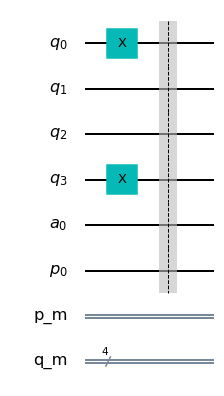

In [18]:
## Aplicamos una compuerta NOT de acuerdo con la info de cadena
for idx in range(nbits):
    if cadena[idx] == '1':
        qc_palindromo.x(cadena_procesada[idx])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Con esto hemos inicializado el espacio necesario para realizar el cómputo. Podemos proceder con el algorimto que hemos propuesto en secciones anteriores.

#### 1. Comparamos parejas de bits

Procedemos a comparar bits correspondientes usando el algoritmo que hemos discutido. Vamos a determinar si los bits correspondientes son iguales. Esta información va a quedar guardada en los últimos ```nbits//2``` del resgitro de la cadena procesada. Para ello, recordemos una identidad lógica importante

$$q_a \oplus q_b = \begin{cases}0 & q_a = q_b \\ 1 & q_A \neq q_b\end{cases}$$

Esta nos capacita para comparar dos bits por medio de compuertas lógicas. De discusiones anteriores, sabemos que el cómputo reversible de XOR se realiza por medio de la compuerta de dos bits CNOT. Presentamos el código que implementa la comparación de bits correspondientes por medio de compuertas CNOT, e incluimos una demostración del resultado de su ejecución. Utilizamos la función miembro ```circuit.barrier()``` para separar distintos módulos de nuestro algoritmo. Esto puede ser útil a la hora de ejecutar algoritmos en dispositivos cuántcos.

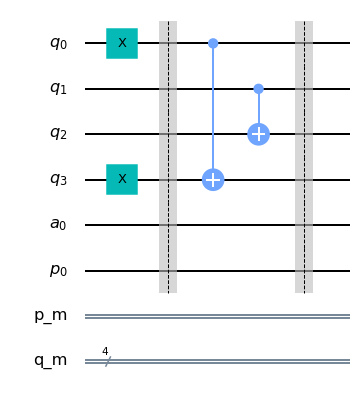

In [19]:
## Aplicamos una compuerta CNOT entre i-ésimo bit y (nbits-1-i)-ésimo bit hasta i = nbits//2
for idx in range(nbits//2):
    qc_palindromo.cx(cadena_procesada[idx],cadena_procesada[nbits-idx-1])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

#### 2. Cálculo ANDs y copia del resultado

Este paso general consta de dos partes:

1. Calcular el valor de la proposición $q'_0 \land q'_1 \land \cdots \land q'_{n/2}$.
1. Copiar el resultado para poder deshacer el cómputo.

##### 2.1 Cálculo ANDs : $q'_0 \land q'_1 \land \cdots \land q'_{n/2}$

Recordemos que si dos bits tienen el mismo valor, la compuerta CNOT cambia al bit objetivo al estado 0. Por tanto, debemos pasar los bits que tienen el resultado de la comparación por compuertas NOT.

> Esto garantiza que cada bit contiene el valor de verdad de las proposiciones $q'_i$ que discutimos en el análisis del problema.

Adjuntamos las líneas de código que realizan esta acción, así como una barrera para identificar esta etapa del algoritmo.

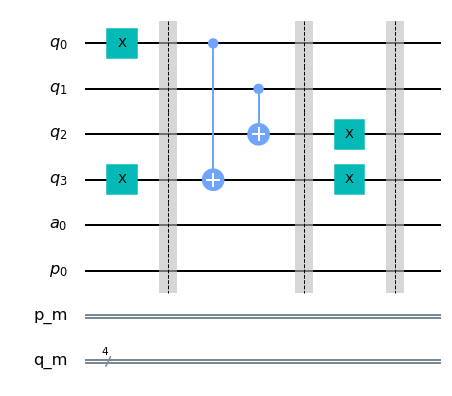

In [20]:
## Aplicamos las NOT
offset = nbits//2 + (nbits&1)
for idx in range(offset,nbits):
    qc_palindromo.x(cadena_procesada[idx])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output='mpl')

Para evaluar si todos los ```nbits//2``` de la segunda mitad del registro de entrada son cero, vamos a aplicar compuertas Toffoli en cascada para recrear la compuerta AND, como vimos anteriormente, para ello utilizaremos los bits de ancila.

**IMPORTANTE:** En los ejemplos teóricos vimos cómo crear una compuerta NOT controlada por 4 bits. Esta sección es una extensión de ese ejemplo. El lector debe asegurarse por sí mismo que la lógica implementada en las siguientes líneas de código en verdad produce el resultado deseado.

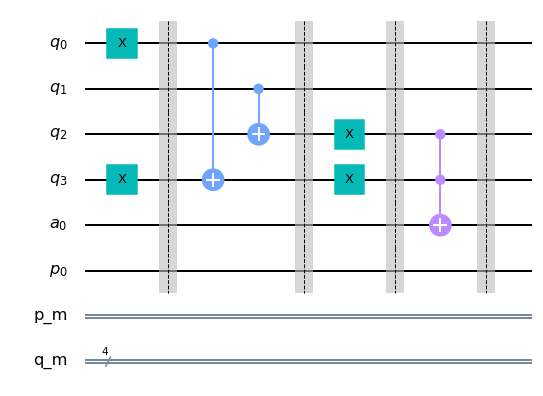

In [21]:
## Determinamos si los últimos nbits//2 bits son todos 0
## Para ello, simulamos NAND utilizando toffoli y NOT
## Luego las toffoli, utilizando los qbits de ancila
qc_palindromo.ccx(cadena_procesada[offset],cadena_procesada[offset+1],ancila[0])
anc_c = 0
anc_o = 1
for idx in range(offset+2,nbits):
    try:
        qc_palindromo.ccx(cadena_procesada[idx],ancila[anc_c],ancila[anc_o])
        anc_c = anc_c + 1
        anc_o = anc_o + 1
    except:
        continue
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

##### 2.2 Copiamos el valor de $q'_0 \land q'_1 \land \cdots \land q'_{n/2}$ para poder medirlo

Como vimos en la componente teórica, la clave de la computación reversible es **deshacer el cómputo**. Por ello necesitamos un registro adicional para copiar el resultado del cómputo que luego vamos a medir. El valor de verdad de $q'_0 \land q'_1 \land \cdots \land q'_{n/2}$ queda guardado en el último bit del registro de ancila. Este es el que debemos copiar en el registro a medir $p_0$. Para ello, utilizamos la propiedad de la compuerta CNOT que hemos visto anteriormente. Adjuntamos las líneas de código que realizan este paso, así como una barrera para identificar claramente cómo se ejecuta el algoritmo.

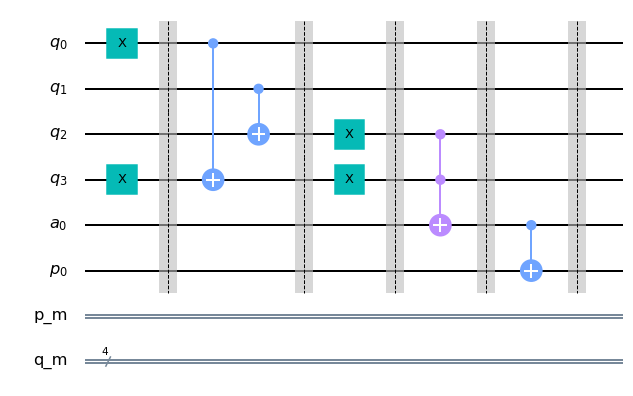

In [22]:
qc_palindromo.cx(ancila[-1],es_palind[0])
## Añadimos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output='mpl')

##### 3. Des-cómputo de los bits de ancila y la cadena procesada

Ahora procedemos a realizar el des-cómputo, revirtiendo todos los pasos hasta la inicialización de la cadena de entrada. Para un científico de la computación esto puede ser un paso un tanto extraño, puesto que aumenta la complejidad en tiempo del algoritmo, sin afectar aparentemente el resultado final del algoritmo. La respuesta a esta inquietud se presentará cuando discutamos los principios de la mecánica cuántica. En breve, los sistemas de varios bits cuánticos tienen una propiedad denominada **entrelazamiento**, que hace que en ciertos casos, no se puedan estudiar sus componentes de manera independiente. Deshacer el cómputo es necesario para romper el entrelazamiento que pueda existir entre los bits de ancila y la cadena de entrada (que no necesitamos) con los bits de resultado que deseamos medir.

En las siguientes líneas de código deshacemos todos los pasos hasta inicializar el espacio computacional. Este último no lo deshacemos pues al final mediremos la cadena de entrada.

**IMPORTANTE:** El lector debe convencerse que los siguientes pasos en verdad reversan el cómputo.

Primero deshacemos el paso 2.1. Esto se ilustra inmediatamente.

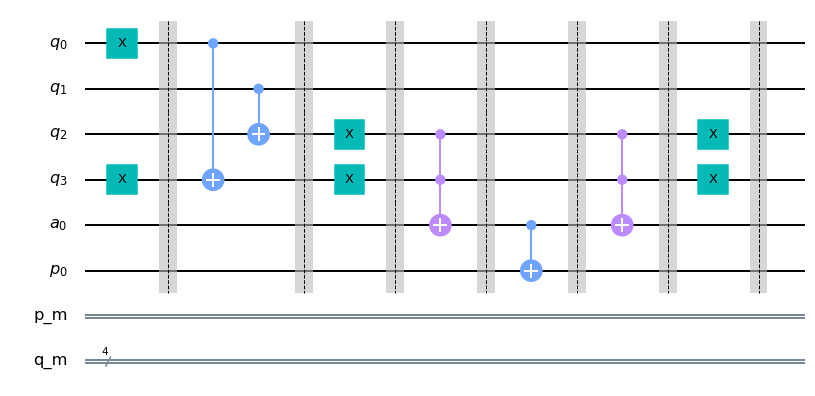

In [23]:
## Desacemos el NAND en cadena
offset = nbits//2 + (nbits&1)
anc_c = nbits//2-3
anc_o = nbits//2-2
for idx in reversed(range(offset+2,nbits)):
    try:
        qc_palindromo.ccx(cadena_procesada[idx],ancila[anc_c],ancila[anc_o])
        anc_c = anc_c - 1
        anc_o = anc_o - 1
    except:
        continue
## Luego las toffoli, utilizando los qbits de ancila
qc_palindromo.ccx(cadena_procesada[offset],cadena_procesada[offset+1],ancila[0])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Finalmente, las NOT
for idx in range(offset,nbits):
    qc_palindromo.x(cadena_procesada[idx])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

Finalmente, deshacemos el cómputo de los bits de comparación (*paso 1*).

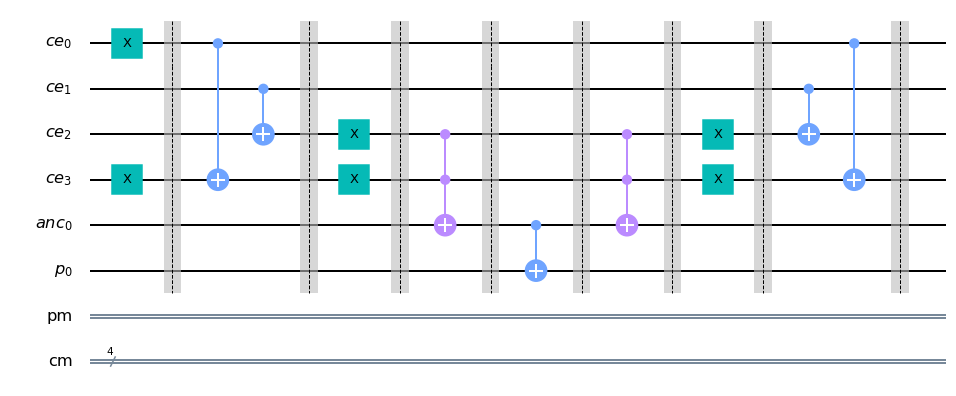

In [169]:
## Aplicamos una compuerta CNOT entre i-ésimo bit y (nbits-1-i)-ésimo bit hasta i = nbits//2
for idx in reversed(range(nbits//2)):
    qc_palindromo.cx(cadena_procesada[idx],cadena_procesada[nbits-idx-1])
## Colocamos una barrera por claridad
qc_palindromo.barrier()
## Dibujamos el circuito
qc_palindromo.draw(output= 'mpl')

## Simulación del Algoritmo

A este punto, hemos implementado el algoritmo en un circuito, y resta observarlo en acción. Para ello, debemos medir la cadena procesada en el registro de cadena medida, y el indicador de si esta es palíndroma, en los registros de medición apropiados. Las líneas de código que logran esto se ilustran a continuación.

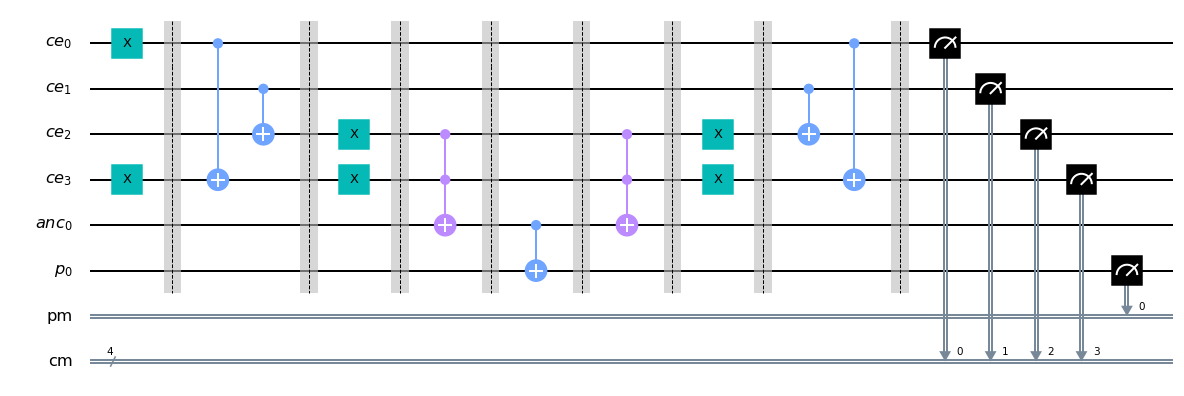

In [170]:
qc_palindromo.measure(cadena_procesada,cadena_medida)
qc_palindromo.measure(es_palind,mido_palind)
## Dibujamos el circuito
qc_palindromo.draw(output='mpl')

Finalmente, simulamos la cadena utilizando el paquete *Aer* de *Qiskit*. Este paquete es uno de los elementos fundamentales de *Qiskit*. En esta serie de cursos **no trataremos sobe los detalles para implementar estos circuitos en un dispositivo de IBM**. Sin embargo, notaremos que cualquier ejecución de un circuito debe realizarse por medio de una plataforma que se denomina *backend*. En este curso utilizaremos el *simulador Qiskit*. Por tanto, pediremos que *Aer* ejecute nuestro circuito utilizando esta plataforma. Esto se logra con el comando 

In [24]:
backend = Aer.get_backend('qasm_simulator')

El simulador brinda una experiencia parecida a la de correr los circuitos en un dispositivo de IBM. Es posible añadir elementos como ruido en los dispositivos, pero esto lo veremos en posts ulteriores. Por el momento, es suficiente con entender que el simulador ejecuta varias veces el circuito, y recopila los resultados medidos en un histograma.

> El histograma de resultados dice todos las posibles salidas tras ejecutar un circuito cuántico, así como las veces que estas fueron reportadas durante las distintas iteraciones del proceso de simulación (o ejecución en un dispositivo de IBM).

A continuación adjuntamos las líneas de código que permiten generar el histograma de resultados que se produce al simular el circuito que hemos construido.

**IMPORTANTE:** Si el lector se encuentra revisando el notebook de Jupyter que tenemos en nuestro entrono de JupyterHub, le invitamos a probar el algoritmo con distintas cadenas y corroborar que en efecto funciona.

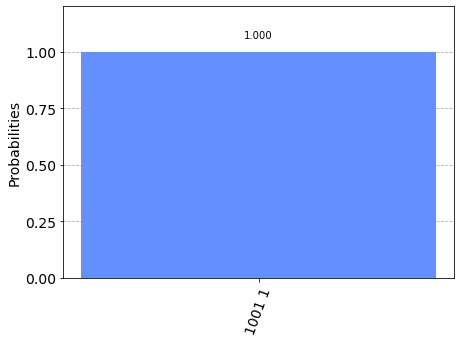

In [171]:
counts = execute(qc_palindromo,backend).result().get_counts()
plot_histogram(counts)

## Perspectivas

1. ¿Puede el lector identificar la forma como se inicializa la cadena? ¿Cómo se diferencia de la manera en que escribiría la cadena en un pedazo de papel?
1. Si el lector corre el notebook de Jupyter designado con una cadena de 3 bits, este reportará errores. ¿Por qué?
1. ¿Puede el lector hacer un circuito que funcione para una cadena de 3 bits o menos?.
1. ¿Existe una forma de realizar el algoritmo anterior *sin bits de ancila* utilizando computación **clásica** reversible?
1. Invitamos al lector a proponer un algoritmo reversible totalmente diferente y compartirlo por medio de nuestro correo oficial. Las respuestas más interesantes será publicada en la página oficial de QC-FEM, con la acreditación correspondiente.

## Referencias

* Nielsen & Chuang. **Quantum Computation and Quantum Information**. Cambridge University Press, 2010.
* E. Rieffel & W. Polak. **Quantum Computing: A Gentle Introduction**. MIT Press, 2011.
* G. Beneti, G. Casati & G. Strini. **Principles of Quantum Computation and Information. Vol. I: Basic Concepts**. World Scientific, 2004.
* V. Silva. **Practical Quantum Computing for Developers**. Apress, 2018.
* T. Norsen. **Foundations of Quantum Mechanics. An Exploration of the Physical Meaning of Quantum Theory**. Springer, 2017.

Muchas gracias por leer esta publicación! Abajo se encuentran links a las lecciones siguientes en el Crash Course de QC-FEM.